## PM-25 Prediction using DAQFF Model

### Importing the libraries and dataset

In [1]:
#Importing libraries and loading dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./T_train.csv',index_col=0)
df_test = pd.read_csv('./T_test.csv',index_col=0)
SAVE_FILE = 'trained_T.h5'
SAVE_IMG = 'graph_T.png'

In [2]:
df.head()

,weather,temperature,pressure,humidity,wind_speed,wind_direction,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration,PM25_Concentration
2014-05-01 00:00:00,0.0,0.568627,0.475410,0.56,0.133333,23.0,0.164141,0.123932,0.088222,0.277929,0.114228,81.0
2014-05-01 01:00:00,0.0,0.549020,0.475410,0.59,0.116667,23.0,0.194444,0.136752,0.116895,0.245232,0.114228,88.0
2014-05-01 02:00:00,0.0,0.549020,0.475410,0.61,0.200000,3.0,0.190657,0.183761,0.149978,0.231608,0.148297,98.0
2014-05-01 03:00:00,0.0,0.509804,0.459016,0.66,0.058333,23.0,0.190657,0.162393,0.107442,0.258856,0.156313,117.0
2014-05-01 04:00:00,0.0,0.529412,0.459016,0.63,0.083333,23.0,0.175505,0.200855,0.112988,0.217984,0.198397,109.0


In [3]:
dataset_columns = df.columns.tolist()
dataset_columns

['weather',
 'temperature',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_direction',
 'PM10_Concentration',
 'NO2_Concentration',
 'CO_Concentration',
 'O3_Concentration',
 'SO2_Concentration',
 'PM25_Concentration']

### Data visualization and pre-processing

<AxesSubplot:>

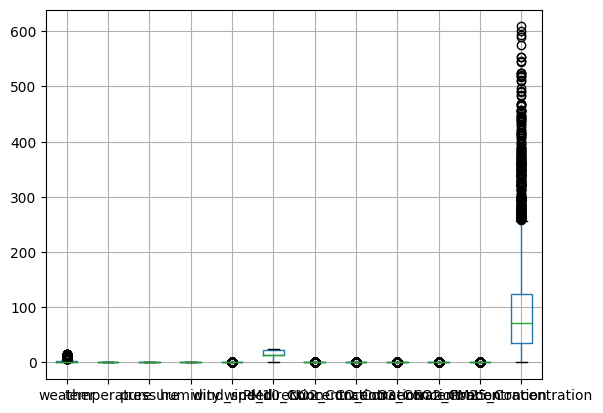

In [4]:
#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

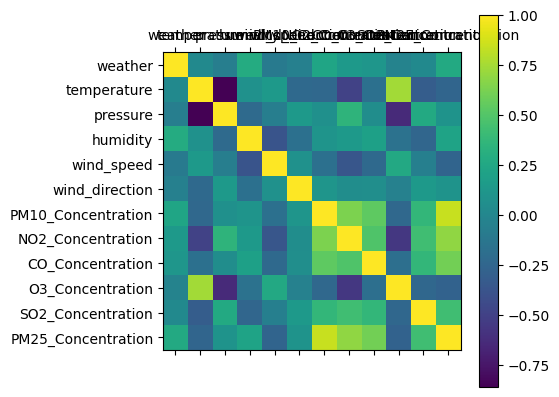

In [6]:
#Analysing relationship between different features
# cor_cols = ['pollution', 'wnd_spd', 'rain', 'snow', 'temp']
cor_cols = dataset_columns
plt.matshow(df.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [7]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(df.values)

In [8]:
#Creating a window for previous data
window_size = 14
def to_supervised(train):
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:-1])
    Y.append(train[i,-1:])

  return X,Y

In [9]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)


Y (6993, 1)
X (6993, 14, 11)


### Modeling the architecture

We have taken the inspiration of this model from the paper [Deep Air Quality Forecasting Using Hybrid Deep
Learning Framework](https://arxiv.org/ftp/arxiv/papers/1812/1812.04783.pdf) by Shengdong Du,Tianrui Li,Yan Yang,Shi-Jinn Horng

#### DAQFF Model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

def DAQFF_model_single_station(input_shape):

    # Feature Extraction with CNNs
    cnn_layers = tf.keras.Sequential([
        layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
        # layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        # layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
        # layers.MaxPooling1D(pool_size=2),
    ])

    # Temporal Dependency Learning with BiLSTM
    bilstm_layer = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True))

    # Prediction Layer
    prediction_layer = layers.Dense(units=1)

    # Model Construction
    inputs = tf.keras.Input(shape=input_shape)
    cnn_output = cnn_layers(inputs)

    # bilstm_input = tf.expand_dims(cnn_output, axis=1)
    bilstm_output = bilstm_layer(cnn_output)
    prediction = prediction_layer(bilstm_output)

    model = tf.keras.Model(inputs=inputs, outputs=prediction)

    # Hyperparameters
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.MeanSquaredError()
    metrics = [tf.keras.metrics.MeanAbsoluteError()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [14]:
model = DAQFF_model_single_station((X.shape[1], X.shape[2]))

### Training the model

In [17]:
model.fit(X,Y, batch_size = 32,epochs=120)

Epoch 1/120


219/219 [==============================] - 8s 17ms/step - loss: 0.0078 - mean_absolute_error: 0.0626
Epoch 2/120
219/219 [==============================] - 4s 18ms/step - loss: 0.0049 - mean_absolute_error: 0.0506
Epoch 3/120
219/219 [==============================] - 4s 17ms/step - loss: 0.0040 - mean_absolute_error: 0.0462
Epoch 4/120
219/219 [==============================] - 4s 17ms/step - loss: 0.0037 - mean_absolute_error: 0.0444
Epoch 5/120
219/219 [==============================] - 4s 17ms/step - loss: 0.0033 - mean_absolute_error: 0.0419
Epoch 6/120
219/219 [==============================] - 4s 17ms/step - loss: 0.0032 - mean_absolute_error: 0.0414
Epoch 7/120
219/219 [==============================] - 4s 17ms/step - loss: 0.0030 - mean_absolute_error: 0.0393
Epoch 8/120
219/219 [==============================] - 4s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0375
Epoch 9/120
219/219 [==============================] - 4s 16ms/step - loss: 0.0027 - mean_absolute_error: 0.

In [29]:
#Taking predictions
from keras.models import load_model
model.save(SAVE_FILE)

### Testing the model

In [30]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test_dataset = scaler.fit_transform(df_test.values)

In [20]:
X_test, Y_test = to_supervised(scaled_test_dataset)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
print('Y' ,Y_test.shape)
print('X' ,X_test.shape)

Y (1715, 1)
X (1715, 14, 11)


In [21]:
loss, mae = model.evaluate(X_test, Y_test)
print("Mean Square Error:", loss)
print("Mean Absolute Error:", mae)

54/54 [==============================] - 2s 7ms/step - loss: 0.0347 - mean_absolute_error: 0.1430
Mean Square Error: 0.034730300307273865
Mean Absolute Error: 0.14302751421928406


In [25]:
#Scaling back to the original scale
d = df_test.values[:(len(scaled_test_dataset)-window_size)]
print('dummy',d.shape)
print('Y_pred',y_new.shape)
Y_predicted = np.concatenate((y_new,d[:,:-1]), axis =1)
print('concat y_pred',y_new.shape)
Y_tested = np.concatenate((Y_test, d[:,:-1]), axis = 1)
print('concat Y_test', Y_test.shape)

dummy (1715, 12)
Y_pred (1715, 1)
concat y_pred (1715, 1)
concat Y_test (1715, 1)


In [26]:
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (1715, 1)
Y_predicted (1715, 1)


In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(Y_tested, Y_predicted)
mae = mean_absolute_error(Y_tested, Y_predicted)

# rmse = np.sqrt(mse)
# rmse
print(f"MSE: {mse}\nMAE: {mae}")

MSE: 8.854683682364403
MAE: 2.279129975670946


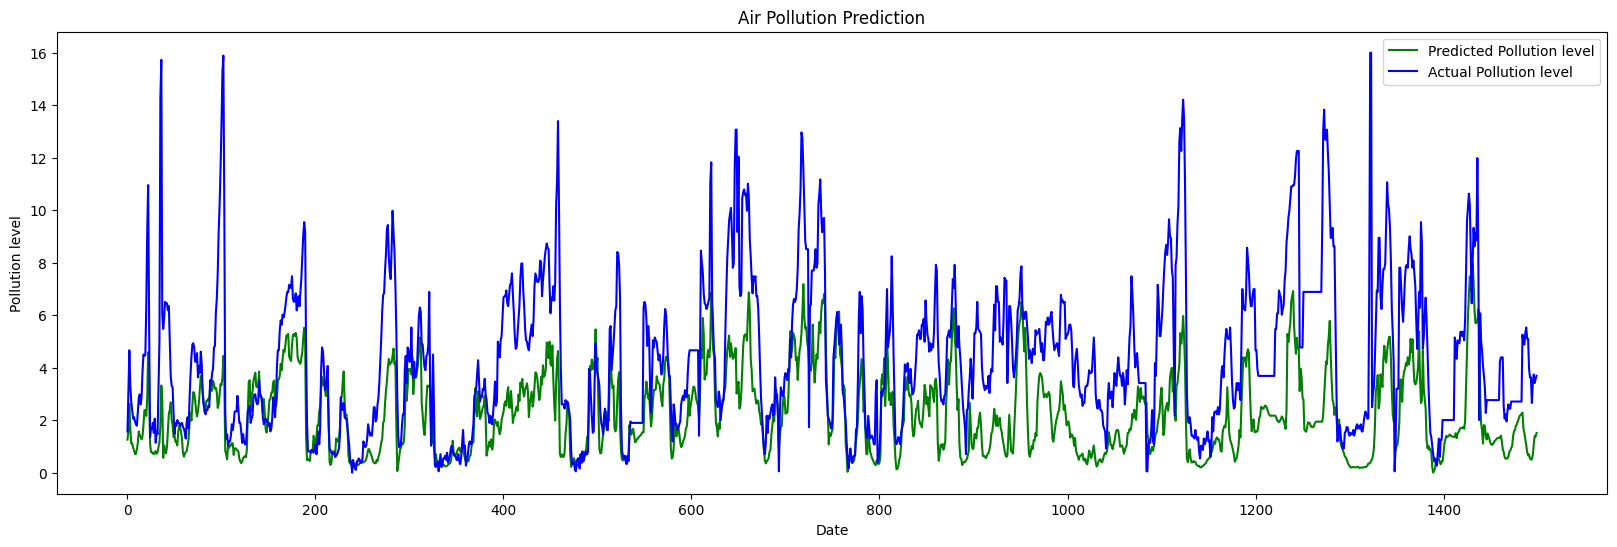

In [28]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(20,6))
plt.plot(Y_predicted[:1500,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_tested[:1500,:] , color = 'blue',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.savefig(SAVE_IMG)
plt.show()